In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy import integrate
import camb
import pyccl as ccl  
from tqdm import tqdm  # optional, for progress bars

from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.integrate import quad

import matplotlib.pyplot as plt

# This is a note shows the calculation of theory angular power spectra of convergence, CIB, Galaxy density fluctuation (both imaging and spectropic survey). The resulting power spectra will be used for the simulation of LSS tracers, which will be used for CMB external delensing.

# Set cosmology

In [2]:
import camb
from camb import model, initialpower


# Set cosmological parameters
params = camb.set_params(H0=67.01904, ombh2=0.02216571, omch2=0.1202944, omk=0, tau=0.06018107, YHe=0.2453006, w=-1.0, wa=0, nt=-0/8.0, nrun=0,\
                    pivot_scalar=0.05, pivot_tensor=0.05, )
params.omegan = 0.0006451439 / (67.01904**2 / 100**2)  # Convert omnuh2 to omegan

# Set dark energy parameters
params.set_dark_energy(w=-1.0)

# Set initial power spectrum parameters
params.InitPower.set_params(As=2.119631e-9, ns=0.9636852, nrun=0.0)

# Set accuracy and lmax parameters
params.set_for_lmax(lmax=7000, lens_potential_accuracy=10, max_eta_k=100000)

# Set additional accuracy parameters
params.Accuracy.AccuracyBoost = 2
params.Accuracy.lAccuracyBoost = 2
params.Accuracy.HighAccuracyDefault = True


# Set other parameters
params.WantCls = True
params.Want_CMB = True
params.WantTransfer = False
params.WantTensors = False
params.WantVectors = False
params.WantScalars = True
params.NonLinear = model.NonLinear_both
params.DoLensing = True
params.Alens = 1.0
params.DoLateRadTruncation = True
params.WantDerivedParameters = True

# Reionization settings
params.Reion.Reionization = True
params.Reion.use_optical_depth = True
params.Reion.optical_depth = 0.06018107
params.Reion.delta_redshift = 0.5
params.Reion.fraction = -1
params.Reion.Helium_redshift = 3.5
params.Reion.Helium_delta_redshift = 0.5
params.Reion.Helium_redshiftstart = 5.0




# Neutrino settings
# Ensure other parameters are correctly set
params.TCMB = 2.7255
params.YHe = 0.2453006
params.num_massless_neutrinos = 2.03066666667
params.num_massive_neutrinos = 1
params.nu_mass_fractions = [1.0]
params.nu_mass_degeneracies = [1.01533333333]
params.share_delta_neff = False

# get results
results = camb.get_results(params)

# Print some derived parameters
print('Omega_m:', params.omegam)
print('H0:', params.H0)


Omega_m: 0.3186092143903546
H0: 67.01904


In [3]:
def z2a(z):
    return 1/(1+z)

def a2z(a):
    return 1/a-1


lmax = 6143 
ls = np.arange(0, lmax+1)
zs = np.linspace(1e-4, 30, 3000)
dz = zs[1] - zs[0]
as_ = 1.0 / (1.0 + zs)
delta_z = zs[1] - zs[0]

Hzs = results.hubble_parameter(zs)  # Km/s/Mpc
H0 = 67.01904  # Km/s/Mpc

h = H0/100

c = 299792.458   # Km/s


#ombh2=0.02216571
#omch2=0.1202944
#Omega_m = (ombh2+omch2)/h**2

Omega_m = params.omegam
Omega_c = params.omegac
Omega_b = params.omegab
Omega_k = 0
Omega_g = 0

A_s = 2.119631e-9
n_s = 0.9636852

Neff = 2.03066666667

extra_params = {'kmax' : 20, 'lmax' : 7000}

cosmo = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, n_s=n_s, sigma8=None, A_s=A_s, Omega_k=0.0, Omega_g=Omega_g, Neff=None, m_nu=0.0, mass_split='single', w0=-1.0, wa=0.0, T_CMB=2.7255, T_ncdm=0.71611, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryonic_effects=None, mg_parametrization=None, extra_parameters=extra_params)


# Get non-linear matter power

In [4]:
chi_values = ccl.comoving_radial_distance(cosmo, z2a(zs))
chi_star = ccl.comoving_radial_distance(cosmo, z2a(1090))

# previously maybe 2000 points → too coarse
ks = np.logspace(np.log10(1e-4), np.log10(20), len(ls) * 3)
pkz = ccl.nonlin_matter_power(cosmo, ks, z2a(zs))

# Interpolation Pkz, prepared for the Limber approxiamtion intergral

In [5]:
# in order to improve interpolation stability, use log-log interpolation (avoid negative/zero issues)
logk = np.log(ks)
logpk_ks_a = np.log(np.maximum(pkz, 1e-40))  # prevent log(0)

In [6]:
from scipy.interpolate import CubicSpline

Plzs = np.zeros((len(ls), len(zs)))

for iz, z in enumerate(tqdm(zs, desc="Building P(l,z) grid")):

    # Limber relation
    k_l = (ls + 0.5) / chi_values[iz]
    k_l = np.clip(k_l, ks[0], ks[-1])
    
    logk_l = np.log(k_l)
    logPz = logpk_ks_a[iz, :]  # P(k,z)

    spline = CubicSpline(logk, logPz, bc_type="natural")

    # evaluate
    logP_l = spline(logk_l)
    P_l = np.exp(logP_l)

    # small smoothing prevents residual ringing
    from scipy.signal import savgol_filter
    P_l = savgol_filter(P_l, 21, 3)  # (window, poly), adjustable

    Plzs[:, iz] = P_l

Building P(l,z) grid: 100%|██████████| 3000/3000 [00:02<00:00, 1053.54it/s]


In [7]:
from scipy.interpolate import UnivariateSpline

def cal_LSS_power(W1, W2, Hzs, chizs, Plzs, zs, lmax):
    """
    Perform Limber integration to compute angular power spectrum Cl.
    """

    cl = np.zeros(lmax)
    for ell in tqdm(range(lmax), desc="integrating over z"):

        integrand = Hzs/c/chizs**2 * W1 * W2 * Plzs[ell, :]

        # smoothing spline helps suppress numerical noise
        spline = UnivariateSpline(zs, integrand, s=0.00001*np.mean(integrand))

        cl[ell] = spline.integral(zs[0], zs[-1])

    return cl

## Lensing convergence

In [8]:
#Window Function of lensing convergence
norm = 1/np.max(1.5 * (Omega_m/c) * (H0**2/Hzs) * (1+zs) * (chi_values) * (1-chi_values/chi_star))
Wkz_k = 1.5 * (Omega_m/c) * (H0**2/Hzs) * (1+zs) * (chi_values) * (1-chi_values/chi_star)     #* norm

In [9]:
#Power of lensing convergence
clkk = cal_LSS_power(Wkz_k, Wkz_k, Hzs, chi_values, Plzs, zs, lmax+1)
factor = ls*(ls+1)/2
dlpp = clkk *2 /np.pi

integrating over z: 100%|██████████| 6144/6144 [00:02<00:00, 2459.52it/s]


## Cosmic Infrared Background

In [10]:
#Window Function of CIB
z_c = 2
sigma_z = 2

def f_ref(zs, nu=353e9, nu_ref=4955e9):
    h = 6.62607015e-34
    k = 1.380649e-23
    T = 34
    beta = alpha = 2

    znu = (1+zs) * nu
    result = np.where(
        znu <= nu_ref,
        (np.exp(h * znu / k / T) - 1)**(-1) * znu **(beta + 3),
        (np.exp(h * nu_ref / k / T) - 1)**(-1) * nu_ref **(beta + 3) * (znu / nu_ref)**(-alpha)
    )
    return result

def normalize_W(W_raw, z, z_min, z_max):
    W_interp = interp1d(zs, W_raw, kind='cubic', fill_value="extrapolate")
    integral, _ = quad(W_interp, z_min, z_max, epsabs=1e-8, epsrel=1e-8, limit=1000)
    b = 1 / integral
    return b

def get_Wkz_i(zs,nu,):    
    #b_c = 1/np.max(chi_values**2 /Hzs /(1+zs)**2 * np.exp(-(zs-z_c)**2/2/sigma_z**2) * f_ref(zs,nu))
    b_c = normalize_W(chi_values**2 /Hzs /(1+zs)**2 * np.exp(-(zs-z_c)**2/2/sigma_z**2) * f_ref(zs,nu), zs, np.min(zs), np.max(zs),)
    Wkz_i = b_c * chi_values**2 /Hzs /(1+zs)**2 * np.exp(-(zs-z_c)**2/2/sigma_z**2) * f_ref(zs,nu)
    return Wkz_i

Wkz_i = get_Wkz_i(zs,nu=353e9,) * 0.5

In [11]:
def CIB_shot_noise(nu1,nu2):
    """
    These data are from Planck 2013 results. XXX. Cosmic infrared background measurements and implications for star formation Tab.6 and Tab.7.
    For nu1 and nu2, both radio galaxy shot noise and star-forming galaxy shot noise power are (flat power-spectra) in Jy^2/sr.
    """
    C_d_shot = {
    (3000, 3000): (10064, 2013),
    (3000, 857): (4427, 885),
    (3000, 545): (1525, 305),
    (3000, 353): (434, 87),
    (3000, 217): (96, 19),
    (3000, 143): (26, 5),
    (3000, 100): (11, 2),
    (857, 857): (5628, 1126),
    (857, 545): (2655, 531),
    (857, 353): (913, 183),
    (857, 217): (216, 43),
    (857, 143): (56, 11),
    (857, 100): (20, 4),
    (545, 545): (1454, 291),
    (545, 353): (543, 109),
    (545, 217): (135, 27),
    (545, 143): (35, 7),
    (545, 100): (12, 2),
    (353, 353): (225, 45),
    (353, 217): (59, 12),
    (353, 143): (15, 3),
    (353, 100): (5.4, 1.1),
    (217, 217): (16, 3),
    (217, 143): (4.3, 0.9),
    (217, 100): (1.5, 0.3),
    (143, 143): (1.2, 0.2),
    (143, 100): (0.42, 0.08),
    (100, 100): (0.15, 0.03)
    }
    C_r_shot = {
    (857, 857): (4.28, 0.90),
    (857, 545): (2.28, 0.56),
    (857, 353): (2.10, 0.53),
    (857, 217): (1.53, 0.46),
    (857, 143): (2.38, 0.58),
    (857, 100): (2.73, 0.64),
    (545, 545): (2.86, 0.70),
    (545, 353): (2.59, 0.63),
    (545, 217): (1.92, 0.56),
    (545, 143): (2.86, 0.68),
    (545, 100): (3.24, 0.73),
    (353, 353): (3.28, 0.82),
    (353, 217): (2.40, 0.70),
    (353, 143): (3.57, 0.82),
    (353, 100): (4.02, 0.90),
    (217, 217): (3.12, 0.79),
    (217, 143): (3.68, 0.99),
    (217, 100): (4.31, 1.07),
    (143, 143): (6.05, 1.47),
    (143, 100): (6.47, 1.39),
    (100, 100): (8.47, 1.97)
    }
    key = (nu1/1e9,nu2/1e9) if nu1 > nu2 else (nu2/1e9,nu1/1e9)
    if nu1/1e9 != 3000 and nu2/1e9 != 3000:
        return  C_d_shot[key][0] + C_r_shot[key][0] 
    else:
        return C_r_shot[key][0] 
 

In [12]:
clii_shot = CIB_shot_noise(353e9,353e9) / 1e12

integrating over z: 100%|██████████| 6144/6144 [00:00<00:00, 8016.00it/s]


(2.0, 2000.0)

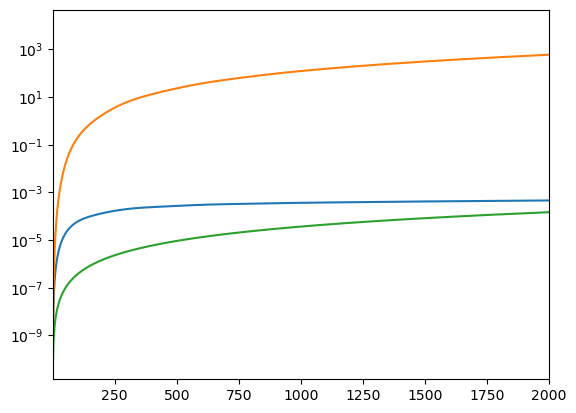

In [13]:
# #Power of CIB
zmax_i = np.int((len(zs)-1)*0.3)

clii = cal_LSS_power(Wkz_i[:zmax_i], Wkz_i[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1)
factor = ls*(ls+1)/2
dlii = clii * factor**2 * 2 /np.pi

clik = cal_LSS_power(Wkz_i[:zmax_i], Wkz_k[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1)
factor = ls*(ls+1)/2
dlik = clik * factor /np.pi

dlii_shot = clii_shot * factor /np.pi


plt.semilogy(ls,dlik,label='$L^2(L+1)^2C_L^{IK}/2/\pi$')
plt.semilogy(ls,dlii,label='$L^2(L+1)^2C_L^{II}/2/\pi$')
plt.semilogy(ls,dlii_shot,label='$L^2(L+1)^2C_L^{II}/2/\pi$')

#plt.ylim(1e-9,1e-6)
plt.xlim(2,2000)

## Galaxy density fluctuation

### Tomographic binning is always beneficial, depending on the surface number density (which decides the shot noise).

### For imaging survey, such as Euclid, LSST, we perform tomographic binning based on photo-z to account for the uncertainty in redshift.

In [14]:
import numpy as np
from scipy.special import erfc, gamma

class GalaxySurvey:
    """
    A class contains used to calculate the window function of galaxy number density, and the shot noise for galaxy auto-power.
    flag: the name of the survey
    bin_bound: the boundary of each tomographic redshift bins
    """
    def __init__(self, flag, bin_bound):
        self.flag = flag
        self.set_survey_parameters()
        self.bin_bound = bin_bound

    def set_survey_parameters(self):
        if self.flag == 'Euclid':
            self.alpha = 2
            self.beta = 1.5
            self.sigma_z = 0.05
            self.z0 = 0.9 / 2**0.5
            #self.bin_bound = np.array([0, 1, 1.5, 2.0, 2.5, 6.0])
            self.n_g = 30
            self.fsky = 0.436

        elif self.flag == 'LSST':
            self.alpha = 2
            self.beta = 1
            self.sigma_z = 0.05
            self.z0 = 0.311
            #self.bin_bound = np.array([0, 0.5, 1.0, 2.0, 3.0, 6.0])
            #self.bin_bound = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.3, 1.7, 2.0, 2.5, 6.0])
            self.n_g = 40
            self.fsky = 0.364

        elif self.flag == 'WFIRST':
            self.alpha = 2
            self.beta = 1.02
            self.sigma_z = 0.05
            self.z0 = 0.6
            #self.bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0])
            self.n_g = 45
            self.fsky = 0.053

        elif self.flag == 'SKA':
            self.alpha = 2
            self.beta = 1.11
            self.sigma_z = 0.05
            self.z0 = 0.63    # calculated with zm = gamma()/gamma() * z0
            #self.bin_bound = np.array([0, 1.0, 2.0, 3.0, 4.5, 6.0])
            self.n_g = 0.0001  # 射电,有点大，暂时不用了
            self.fsky = 0.7  #来自ChatGPT,不确定，未查到数据

        # Calculate mean redshift
        self.zm = gamma((self.alpha + 2) / self.beta) / gamma((self.alpha + 1) / self.beta) * self.z0

    def bias_g(self, z):
        if self.flag == 'Euclid':
            return (1 + z) ** 0.5
        elif self.flag == 'LSST' or self.flag == 'WFIRST':
            return 1 + 0.84 * z
        elif self.flag == 'SKA':
            return 0.94 + 0.43 * z + 0.18 * z ** 2 - 0.0019 * z ** 3

    def bin_zs_sequences(self, zs):
        """
        Splits the `zs` array into bins according to the indices provided in `bin_idx`.
        
        Parameters:
            zs (array-like): The original array of `zs` values.
            bin_idx (array-like): The array of indices that define the bin boundaries.
        
        Returns:
            list of arrays: A list where each element is an array of `zs` values for a bin.
        """
        bin_idx = self.find_nearest(zs, self.bin_bound)
        bins = []
        for i in range(len(bin_idx) - 1):
            bins.append(zs[bin_idx[i]:bin_idx[i + 1]])
        bins.append(zs[bin_idx[-1]:])
        return bins


    def dist_g(self, zmin, zmax, z):
        sigma_zs = (1 + z) * self.sigma_z
        return 0.5 * (erfc((zmin - z) / np.sqrt(2) / sigma_zs) - erfc((zmax - z) / np.sqrt(2) / sigma_zs))

    def find_nearest(self, data, x):    
        kh_tree = cKDTree(data.reshape(-1, 1))

        # 查找 k_values 在 kh 中的最近邻
        distances, indices = kh_tree.query(x.reshape(-1, 1))

        # 打印结果
        #for k, idx in zip(x, indices):
                #print(f'k = {k:.6e}, closest index in kh = {idx}, k[idx] = {data[idx]:.6e}, relavant error = {np.abs(k/data[idx]-1):.6e}')

        return indices 


    def cal_galaxy_window(self, zs, Hzs):
        bin_idx = self.find_nearest(zs, self.bin_bound)
        zs_binned = self.bin_zs_sequences(zs)
        Hzs_binned = self.bin_zs_sequences(Hzs)

        def der(z, Hz, zmin, zmax):
            return self.beta * Hz / gamma((self.alpha + 1) / self.beta) * \
                   (z ** self.alpha / self.z0 ** (self.alpha + 1)) * np.exp(-(z / self.z0) ** self.beta) * \
                   self.dist_g(zmin, zmax, z) / Hz

        Wkz_gs = []
        dndchi = []
        for i in range(len(bin_idx) - 1):
            zmin = np.min(zs_binned[i])
            zmax = np.max(zs_binned[i])
            inte_kernal = der(zs, Hzs, zmin, zmax) 
            inte_kernal /= np.trapz(inte_kernal, zs)
            Wkz_gs.append(self.bias_g(zs) * inte_kernal)
            dndchi.append(inte_kernal)
        return zs_binned, Wkz_gs, dndchi


    def get_shot_noise_a2s(self, n_g_arcmin2):
        # conversion factor: arcmin^-2 to steradian^-1
        arcmin2_to_sr = (np.pi / (180 * 60))**2

        # convert to sr^-1
        n_sr = n_g_arcmin2 / arcmin2_to_sr
        
        # shot noise Cl = 1/n_sr
        return 1 / n_sr

    def shot_noises(self, zs):
        dz = zs[1] - zs[0]

        nz_tot = (
            self.beta
            / gamma((self.alpha + 1) / self.beta)
            * (zs ** self.alpha / self.z0 ** (self.alpha + 1))
            * np.exp(-(zs / self.z0) ** self.beta)
        )
        nz_tot /= np.trapz(nz_tot, zs)

        P_sn, ngs = [], []

        for i in range(len(self.bin_bound)-1):
            zmin, zmax = self.bin_bound[i:i+2]
            p_i = nz_tot * self.dist_g(zmin, zmax, zs)
            f_i = np.trapz(p_i, zs)

            n_gi = self.n_g * f_i
            ngs.append(n_gi)
            P_sn.append(self.get_shot_noise_a2s(n_gi))

        return P_sn, ngs


In [15]:
Euclid_survey = GalaxySurvey(flag='Euclid', bin_bound = np.array([0, 0.5, 1.0, 1.5, 2.0, 6.0, ]))

zs_binned, Wkz_gs_Euclid_bin, dndz_Euclid_bin = Euclid_survey.cal_galaxy_window(zs, Hzs,)
P_sn_Euclid, ngs_Euclid = Euclid_survey.shot_noises(zs,)

Wkz_gs_Euclid_tomo = np.sum(Wkz_gs_Euclid_bin, axis=0)

In [16]:
np.sum(ngs_Euclid)

29.992512607760997

1.0
0.9999999999999999
0.9999999999999999
1.0
1.0


(0.0, 6.0)

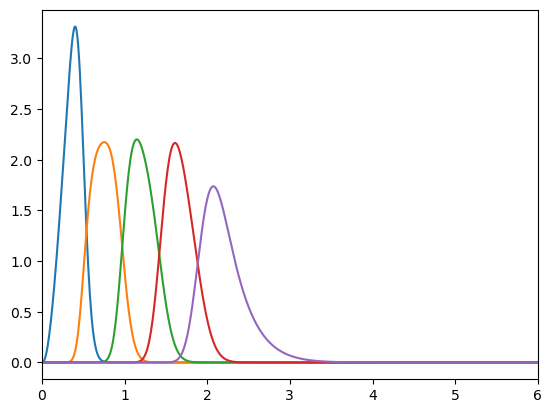

In [17]:
for i in range(len(Wkz_gs_Euclid_bin)):
    plt.plot(zs, dndz_Euclid_bin[i], label=f'Bin {i+1}')
    print(np.trapz(dndz_Euclid_bin[i], zs))

plt.xlim(0,6)

In [18]:
Euclid_survey = GalaxySurvey(flag='Euclid', bin_bound = np.array([0,  6.0]))

zs_full, Wkz_gs_Euclid, dndz_Euclid = Euclid_survey.cal_galaxy_window(zs, Hzs, )

P_sn_Euclid_full, ng_full = Euclid_survey.shot_noises(zs, )

(0.0, 6.0)

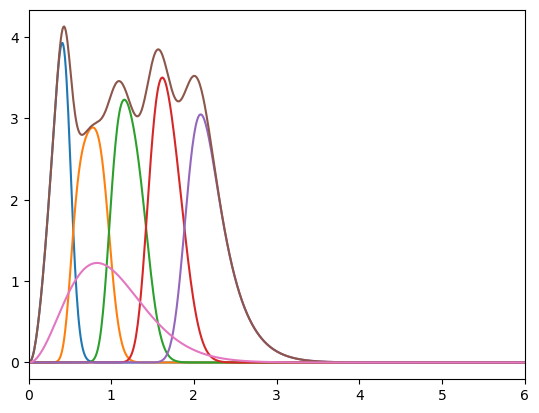

In [19]:
for i in range(len(Wkz_gs_Euclid_bin)):
    plt.plot(zs, Wkz_gs_Euclid_bin[i], label=f'Bin {i+1}')

plt.plot(zs, np.sum(Wkz_gs_Euclid_bin, axis=0), label='Sum')
plt.plot(zs, Wkz_gs_Euclid[0], label='Full')
plt.xlim(0, 6)

In [20]:
tracers = {'kappa':Wkz_k, 'Euclid1': Wkz_gs_Euclid_bin[0], 'Euclid2': Wkz_gs_Euclid_bin[1], 'Euclid3': Wkz_gs_Euclid_bin[2], 'Euclid4': Wkz_gs_Euclid_bin[3], 'Euclid5': Wkz_gs_Euclid_bin[4]}#

# 初始化一个6x6的结果数组
result_matrix = np.zeros((len(tracers.keys()), len(tracers.keys()), lmax+1))

# 获取tracers的键名列表
tracer_keys = list(tracers.keys())

zmax = 600


# 计算不同tracer组合之间的cal_LSS_power
for i, key1 in enumerate(tracer_keys):
    for j, key2 in enumerate(tracer_keys):
        W1 = tracers[key1][:zmax]
        W2 = tracers[key2][:zmax]
        result = cal_LSS_power(W1[:zmax], W2[:zmax], Hzs[:zmax], chi_values[:zmax], Plzs[:, :zmax], zs[:zmax], lmax+1)
        if i==j and i!=0:
            result += P_sn_Euclid[i-1]
        result_matrix[i, j, :] = result

integrating over z: 100%|██████████| 6144/6144 [00:01<00:00, 5339.76it/s]


In [21]:
rho_eff_euclid_tomo = 0
clii_inv = np.zeros((len(tracer_keys)-1, len(tracer_keys)-1, lmax+1))
for ell in range(lmax+1):
    clii = result_matrix[1:, 1:, ell]
    clii_inv[:, :, ell] = np.linalg.inv(clii)
for i in range(1, len(tracer_keys)):
    for j in range(1, len(tracer_keys)):
        rho_eff_euclid_tomo += result_matrix[0, i, :] * clii_inv[i-1, j-1, :] * result_matrix[0, j, :]
rho_eff_euclid_tomo /= clkk

rho_eff_euclid_tomo = np.sqrt(rho_eff_euclid_tomo)

In [22]:
Wgs = np.array([Wkz_gs_Euclid[0], ])
P_sn = np.array([P_sn_Euclid_full[0], ])

zmax_i = 600

rhos_full = []
for i,w in enumerate(Wgs):
    clgg = cal_LSS_power(w[:zmax_i], w[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1) + P_sn[i]
    clgk = cal_LSS_power(w[:zmax_i], Wkz_k[:zmax_i], Hzs[:zmax_i], chi_values[:zmax_i], Plzs[:,:zmax_i], zs[:zmax_i], lmax+1)
    rhos_full.append(clgk/(clgg*clkk)**0.5)

integrating over z: 100%|██████████| 6144/6144 [00:00<00:00, 10558.44it/s]


Text(0, 0.5, 'Correlation coefficient $\\rho_L$')

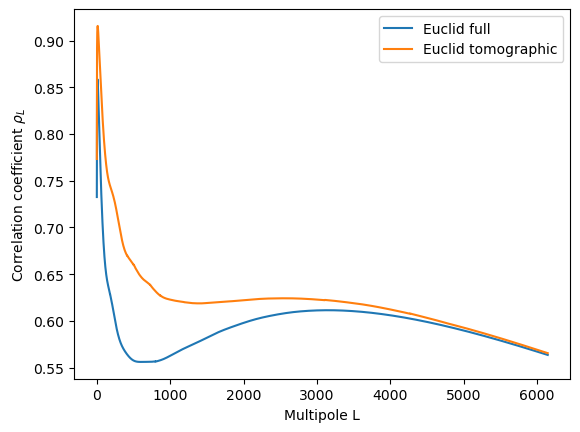

In [23]:
plt.plot(rhos_full[0], label='Euclid full')
plt.plot(rho_eff_euclid_tomo, label='Euclid tomographic')


#plt.xlim(0, 1000)
plt.legend()
plt.xlabel('Multipole L')
plt.ylabel(r'Correlation coefficient $\rho_L$')

## For spectropic survey such as DESI, MUST, we work based on the redshift distribution they provided (usually several tracers extended to high redshift). And tomographic binning will not overlap thanks to their high accuracy in redshift measurement.

#### These data are provided by MUST collaboration. (https://arxiv.org/abs/2411.07970)

In [24]:
must_data = np.load('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/LSS_tracer_simulation/data_nz_bias.npz', allow_pickle=True)
density = must_data['density'].item()
nz_bgs = density['BGS']
nz_lrg = density['LRG']
nz_elg = density['ELG']
nz_qso = density['QSO']
nz_udrop = density['udrop']
nz_gdrop = density['gdrop']
nz_rdrop = density['rdrop']

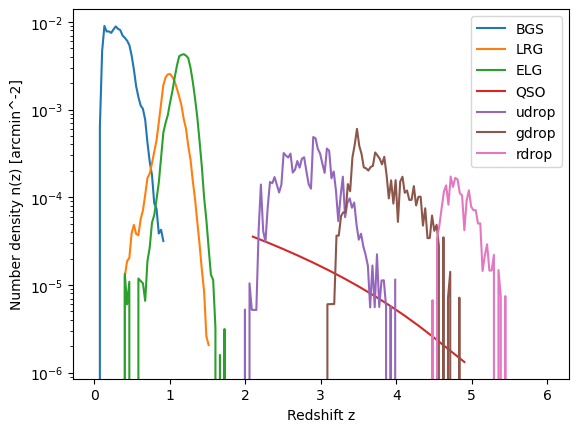

In [25]:
plt.semilogy(nz_bgs['z'], nz_bgs['n'], label='BGS')
plt.semilogy(nz_lrg['z'], nz_lrg['n'], label='LRG')
plt.semilogy(nz_elg['z'], nz_elg['n'], label='ELG')
plt.semilogy(nz_qso['z'], nz_qso['n'], label='QSO')
plt.semilogy(nz_udrop['z'], nz_udrop['n'], label='udrop')
plt.semilogy(nz_gdrop['z'], nz_gdrop['n'], label='gdrop')
plt.semilogy(nz_rdrop['z'], nz_rdrop['n'], label='rdrop')
plt.xlabel('Redshift z')
plt.ylabel('Number density n(z) [arcmin^-2]')
plt.legend()

#### We first get a smooth distribution n(z) based on data, either via interpolation or Kernel Density estimate.

In [26]:
def from_data_2_kde(z, nz, bandwidth=0.02):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.neighbors import KernelDensity

    #z = nz['z']            # bin centers
    #nz = nz['n']           # your dN/dz (or bin heights)

    # 1) fit KDE on the binned centroids with weights
    kde = KernelDensity(kernel='epanechnikov', bandwidth=bandwidth)
    kde.fit(z[:, None], sample_weight=nz)   # 注意：sample_weight 可以是 counts 或密度权重

    # 2) evaluate on a fine grid (use many points, not 30)
    z_fine = np.linspace(z.min(), z.max(), int((z.max()-z.min())/delta_z))
    logpdf = kde.score_samples(z_fine[:, None])
    pdf_kde = np.exp(logpdf)   # this is a density shape, usually normalized to integrate ~1

    # 3) scale KDE so its area matches your original nz area
    area_data = np.trapz(nz, z)         # integral of your binned curve (≈ total counts per unit area)
    area_kde  = np.trapz(pdf_kde, z_fine)
    scale = area_data / area_kde
    pdf_kde *= scale
    return z_fine, pdf_kde


def from_data_2_log_spline(z, nz, s_factor=1e-4):
    from scipy.interpolate import UnivariateSpline

    mask = nz > 0
    z0 = z[mask]
    logn = np.log(nz[mask])

    s = s_factor * np.sum(logn**2)
    spline = UnivariateSpline(z0, logn, s=s)

    z_fine = np.linspace(z0.min(), z0.max(), int((z0.max()-z0.min())/delta_z))
    nz_curve = np.exp(spline(z_fine))
    return z_fine, nz_curve


#width1 = 0.05

# z_fine_bgs, nz_fine_bgs = from_data_2_kde(nz_bgs['z'], nz_bgs['n'], bandwidth=width1)
# z_fine_lrg, nz_fine_lrg = from_data_2_kde(nz_lrg['z'], nz_lrg['n'], bandwidth=width1)
# z_fine_elg, nz_fine_elg = from_data_2_kde(nz_elg['z'], nz_elg['n'], bandwidth=width1)
# z_fine_qso, nz_fine_qso = from_data_2_kde(nz_qso['z'], nz_qso['n'], bandwidth=0.7)

z_fine_bgs, nz_fine_bgs = from_data_2_log_spline(nz_bgs['z'], nz_bgs['n'], s_factor=0.0001)
z_fine_lrg, nz_fine_lrg = from_data_2_log_spline(nz_lrg['z'], nz_lrg['n'], s_factor=0.0001)
z_fine_elg, nz_fine_elg = from_data_2_log_spline(nz_elg['z'], nz_elg['n'], s_factor=0.0001)
z_fine_qso, nz_fine_qso = from_data_2_log_spline(nz_qso['z'], nz_qso['n'], s_factor=0.0001)

z_fine_udrop, nz_fine_udrop = from_data_2_kde(nz_udrop['z'], nz_udrop['n'], bandwidth=0.2)
z_fine_gdrop, nz_fine_gdrop = from_data_2_kde(nz_gdrop['z'], nz_gdrop['n'], bandwidth=0.2)
z_fine_rdrop, nz_fine_rdrop = from_data_2_kde(nz_rdrop['z'], nz_rdrop['n'], bandwidth=0.1)

/home/chen/anaconda3/envs/lens/lib/python3.10/site-packages/sklearn/neighbors/_kde.py:274: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/chen/anaconda3/envs/lens/lib/python3.10/site-packages/sklearn/neighbors/_kde.py:274: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(
/home/chen/anaconda3/envs/lens/lib/python3.10/site-packages/sklearn/neighbors/_kde.py:274: RuntimeWarning: divide by zero encountered in log
  log_density = self.tree_.kernel_density(


#### Pad the distribution n(z) to the global length of z-array (0,30).

In [27]:
import numpy as np

def pad_nz_to_zs(zs,z_fine,nz_fine,fill_value=0.0):
    """
    Pad a tracer n(z) defined on z_fine onto a global zs grid.

    Parameters
    ----------
    zs : array
        Global redshift grid (e.g. 1e-4 → 30, Δz=0.01)
    z_fine : array
        Tracer redshift grid (subset of zs)
    nz_fine : array
        n(z) values defined on z_fine
    fill_value : float
        Value outside tracer redshift range (default 0)

    Returns
    -------
    nz_on_zs : array
        n(z) evaluated on zs, with zeros outside coverage
    """

    nz_on_zs = np.full_like(zs, fill_value, dtype=float)

    # only interpolate inside tracer z range
    zmin, zmax = z_fine.min(), z_fine.max()
    mask = (zs >= zmin) & (zs <= zmax)

    nz_on_zs[mask] = np.interp(
        zs[mask],
        z_fine,
        nz_fine,
        left=fill_value,
        right=fill_value
    )

    return nz_on_zs


nz_global_bgs = pad_nz_to_zs(zs, z_fine_bgs, nz_fine_bgs)
nz_global_lrg = pad_nz_to_zs(zs, z_fine_lrg, nz_fine_lrg)
nz_global_elg = pad_nz_to_zs(zs, z_fine_elg, nz_fine_elg)
nz_global_qso = pad_nz_to_zs(zs, z_fine_qso, nz_fine_qso)
nz_global_udrop = pad_nz_to_zs(zs, z_fine_udrop, nz_fine_udrop)
nz_global_gdrop = pad_nz_to_zs(zs, z_fine_gdrop, nz_fine_gdrop)
nz_global_rdrop = pad_nz_to_zs(zs, z_fine_rdrop, nz_fine_rdrop)

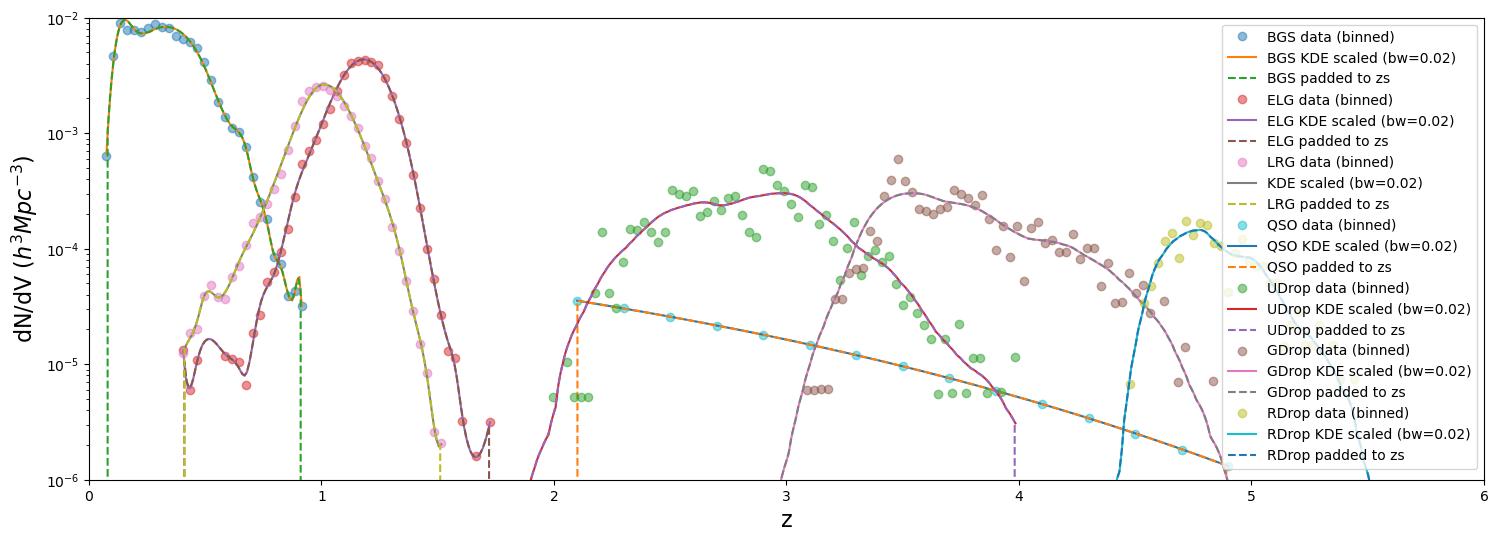

In [28]:
plt.figure(figsize=(18,6))

plt.semilogy(nz_bgs['z'], nz_bgs['n'], 'o', alpha=0.5, label='BGS data (binned)')
plt.semilogy(z_fine_bgs, nz_fine_bgs, '-', label=f'BGS KDE scaled (bw=0.02)')
plt.semilogy(zs, nz_global_bgs, '--', label='BGS padded to zs')


plt.semilogy(nz_elg['z'], nz_elg['n'], 'o', alpha=0.5, label='ELG data (binned)')
plt.semilogy(z_fine_elg, nz_fine_elg, '-', label=f'ELG KDE scaled (bw=0.02)')
plt.semilogy(zs, nz_global_elg, '--', label='ELG padded to zs')

plt.semilogy(nz_lrg['z'], nz_lrg['n'], 'o', alpha=0.5, label='LRG data (binned)')
plt.semilogy(z_fine_lrg, nz_fine_lrg, '-', label=f'KDE scaled (bw=0.02)')
plt.semilogy(zs, nz_global_lrg, '--', label='LRG padded to zs')


plt.semilogy(nz_qso['z'], nz_qso['n'], 'o', alpha=0.5, label='QSO data (binned)')
plt.semilogy(z_fine_qso, nz_fine_qso, '-', label=f'QSO KDE scaled (bw=0.02)')
plt.semilogy(zs, nz_global_qso, '--', label='QSO padded to zs')

plt.semilogy(nz_udrop['z'], nz_udrop['n'], 'o', alpha=0.5, label='UDrop data (binned)')
plt.semilogy(z_fine_udrop, nz_fine_udrop, '-', label=f'UDrop KDE scaled (bw=0.02)')
plt.semilogy(zs, nz_global_udrop, '--', label='UDrop padded to zs')

plt.semilogy(nz_gdrop['z'], nz_gdrop['n'], 'o', alpha=0.5, label='GDrop data (binned)')
plt.semilogy(z_fine_gdrop, nz_fine_gdrop, '-', label=f'GDrop KDE scaled (bw=0.02)')
plt.semilogy(zs, nz_global_gdrop, '--', label='GDrop padded to zs')

plt.semilogy(nz_rdrop['z'], nz_rdrop['n'], 'o', alpha=0.5, label='RDrop data (binned)')
plt.semilogy(z_fine_rdrop, nz_fine_rdrop, '-', label=f'RDrop KDE scaled (bw=0.02)')
plt.semilogy(zs, nz_global_rdrop, '--', label='RDrop padded to zs')

plt.legend()
plt.xlabel('z', fontsize=16)
plt.ylabel('dN/dV $(h^3 Mpc^{-3})$', fontsize=16)
plt.ylim(1e-6, 1e-2)
plt.xlim(0, 6)

plt.show()

#### From 3D distribution n(z) [h^3 Mpc^-3] to projected dN/dz [arcmin^-2].

In [29]:
import numpy as np

def n3D_to_dNdz_arcmin2(
    n3D,      # h^3 Mpc^-3
    z,
    chi,      # comoving distance [Mpc/h]
    H,        # Hubble parameter [km/s/Mpc]
    h,
    if_deg=False
):
    """
    Convert 3D number density n(z) [h^3 Mpc^-3]
    to projected dN/dz [arcmin^-2].

    Parameters
    ----------
    n3D : array
        3D number density [h^3 Mpc^-3]
    z : array
        Redshift grid
    chi : array
        Comoving distance [Mpc/h]
    H : array
        Hubble parameter H(z) [km/s/Mpc]
    h : float
        Dimensionless Hubble parameter

    Returns
    -------
    dNdz_arcmin2 : array
        Projected redshift distribution [arcmin^-2]
    """

    c = 299792.458  # km/s

    # ---- 3D → per dz per sr ----
    dNdz_dOmega = n3D * (c / H) * chi**2

    # ---- sr → arcmin^2 ----
    sr_to_arcmin2 = (180 / np.pi)**2 if if_deg else (180 / np.pi)**2 * 3600
    dNdz_arcmin2 = dNdz_dOmega / sr_to_arcmin2

    return dNdz_arcmin2



dndz_global_bgs = n3D_to_dNdz_arcmin2(nz_global_bgs, zs, chi_values, Hzs, h, if_deg=True)
dndz_global_lrg = n3D_to_dNdz_arcmin2(nz_global_lrg, zs, chi_values, Hzs, h, if_deg=True)
dndz_global_elg = n3D_to_dNdz_arcmin2(nz_global_elg, zs, chi_values, Hzs, h, if_deg=True)
dndz_global_qso = n3D_to_dNdz_arcmin2(nz_global_qso, zs, chi_values, Hzs, h, if_deg=True)
dndz_global_udrop = n3D_to_dNdz_arcmin2(nz_global_udrop, zs, chi_values, Hzs, h, if_deg=True)
dndz_global_gdrop = n3D_to_dNdz_arcmin2(nz_global_gdrop, zs, chi_values, Hzs, h, if_deg=True)
dndz_global_rdrop = n3D_to_dNdz_arcmin2(nz_global_rdrop, zs, chi_values, Hzs, h, if_deg=True)

#### Notice, so far it hasn't considered the fiber constraint, but only the result with certain selection strategies under the true distribution

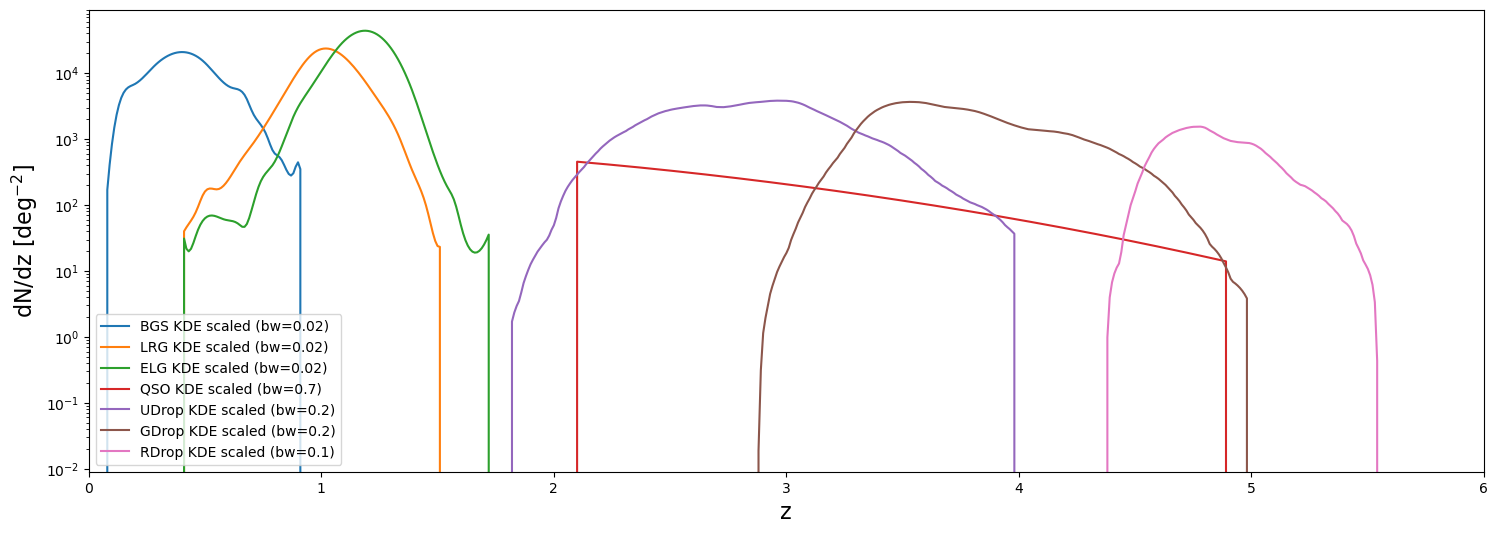

In [30]:
plt.figure(figsize=(18,6))

plt.semilogy(zs, dndz_global_bgs, '-', label=f'BGS KDE scaled (bw=0.02)')
plt.semilogy(zs, dndz_global_lrg, '-', label=f'LRG KDE scaled (bw=0.02)')
plt.semilogy(zs, dndz_global_elg, '-', label=f'ELG KDE scaled (bw=0.02)')
plt.semilogy(zs, dndz_global_qso, '-', label=f'QSO KDE scaled (bw=0.7)')
plt.semilogy(zs, dndz_global_udrop, '-', label=f'UDrop KDE scaled (bw=0.2)')
plt.semilogy(zs, dndz_global_gdrop, '-', label=f'GDrop KDE scaled (bw=0.2)')
plt.semilogy(zs, dndz_global_rdrop, '-', label=f'RDrop KDE scaled (bw=0.1)')


plt.legend()
plt.xlabel('z', fontsize=16)
plt.ylabel('dN/dz [deg$^{-2}$]', fontsize=16)
#plt.ylim(1e-3, 1e2)
plt.xlim(0, 6)
plt.show()

#### Below we decide the final distribution, with total surface density given by https://arxiv.org/abs/2411.07970.

In [31]:
def Nz_from_total_density(z_fine,nz_fine,n,clip_negative=True):
    """
    Construct dn/dz from surface density n and a redshift shape n(z).

    Parameters
    ----------
    z_fine : array
        Fine redshift grid
    nz_fine : array
        Unnormalized redshift distribution shape
    n : float
        Total surface density [arcmin^-2] or [deg^-2]
    clip_negative : bool
        Whether to clip negative spline/KDE artifacts

    Returns
    -------
    dNdz : array
        dN/dzd$\Omega$ evaluated on z_fine [arcmin^-2 per unit z] or [deg^-2 per unit z]
    """

    nz = np.array(nz_fine, copy=True)

    if clip_negative:
        nz[nz < 0] = 0.0


    dz = z_fine[1] - z_fine[0]
    norm = np.trapz(nz, z_fine, dz)
     
    if norm <= 0:
        raise ValueError("nz_fine integrates to zero or negative.")

    dNdz = n * nz / norm
    return dNdz

In [32]:
dNdz_bgs = Nz_from_total_density(zs, dndz_global_bgs, n=2500)  # [deg^-2]
dNdz_lrg = Nz_from_total_density(zs, dndz_global_lrg, n=2000)    # [deg^-2]
dNdz_elg = Nz_from_total_density(zs, dndz_global_elg, n=3600)    # [deg^-2]
dNdz_qso = Nz_from_total_density(zs, dndz_global_qso, n=260)    # [deg^-2]
dNdz_udrop = Nz_from_total_density(zs, dndz_global_udrop, n=1500)    # [deg^-2]
dNdz_gdrop = Nz_from_total_density(zs, dndz_global_gdrop, n=760)    # [deg^-2]
dNdz_rdrop = Nz_from_total_density(zs, dndz_global_rdrop, n=390)    # [deg^-2]

In [33]:
def normalize_dNdz(dNdz, z, dz):
    """
    Normalize dN/dz so that its integral over z equals 1.

    Parameters
    ----------
    dNdz : array
        Redshift distribution [per unit z]
    z : array
        Redshift grid
    dz : float
        Redshift step size

    Returns
    -------
    dNdz_normalized : array
        Normalized redshift distribution
    """

    integral = np.trapz(dNdz, z, dz)
    if integral == 0:
        raise ValueError("Integral of dN/dz is zero, cannot normalize.")
    return dNdz / integral

dNdz_bgs = normalize_dNdz(dNdz_bgs, zs, dz)
dNdz_lrg = normalize_dNdz(dNdz_lrg, zs, dz)
dNdz_elg = normalize_dNdz(dNdz_elg, zs, dz)
dNdz_qso = normalize_dNdz(dNdz_qso, zs, dz)
dNdz_udrop = normalize_dNdz(dNdz_udrop, zs, dz)
dNdz_gdrop = normalize_dNdz(dNdz_gdrop, zs, dz)
dNdz_rdrop = normalize_dNdz(dNdz_rdrop, zs, dz)

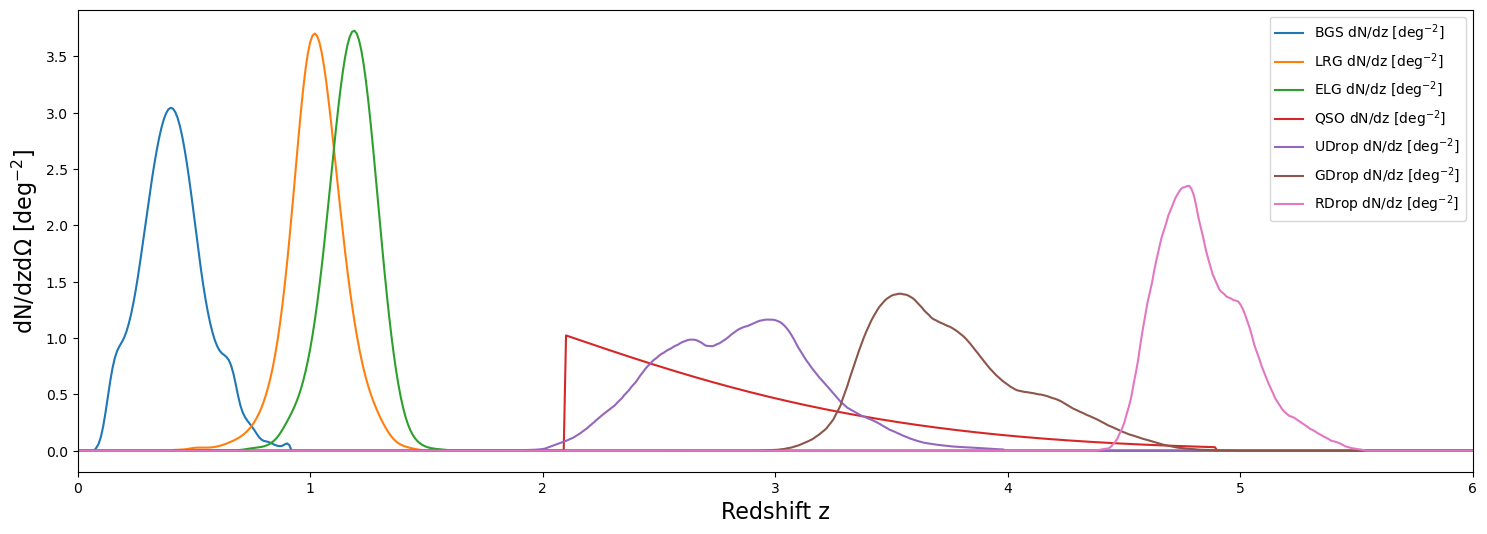

In [34]:
plt.figure(figsize=(18,6))
plt.plot(zs, dNdz_bgs, label='BGS dN/dz [deg$^{-2}$]')
plt.plot(zs, dNdz_lrg, label='LRG dN/dz [deg$^{-2}$]')
plt.plot(zs, dNdz_elg, label='ELG dN/dz [deg$^{-2}$]')
plt.plot(zs, dNdz_qso, label='QSO dN/dz [deg$^{-2}$]')
plt.plot(zs, dNdz_udrop, label='UDrop dN/dz [deg$^{-2}$]')
plt.plot(zs, dNdz_gdrop, label='GDrop dN/dz [deg$^{-2}$]')
plt.plot(zs, dNdz_rdrop, label='RDrop dN/dz [deg$^{-2}$]')
plt.xlabel('Redshift z', fontsize=16)
plt.ylabel('dN/dzd$\Omega$ [deg$^{-2}$]', fontsize=16)
#plt.semilogy()
#plt.ylim(1e-1,2e2)
plt.xlim(0,6)
plt.legend()

#### Next, we define a class to calculate the window function and shot noise for MUST tracers.

In [35]:
import numpy as np
from scipy.special import erfc, gamma


class GalaxySurvey_MUST:
    """
    A class contains used to calculate the window function of galaxy number density, and the shot noise for galaxy auto-power.
    flag: the name of the survey
    bin_bound: the boundary of each tomographic redshift bins
    """

    def __init__(self, flag, bin_bound):
        self.flag = flag              # ① 先定义
        self.bin_bound = bin_bound    # ② 再定义
        self.set_survey_parameters()  # ③ 最后使用


        self.a = z2a(zs)
        self.Dzs = ccl.growth_factor(cosmo, self.a)

    def set_survey_parameters(self):
        if self.flag == 'BGS':
            self.nz = dNdz_bgs
            self.n_g_arcmin2 = 2500 * (1/60)**2   # arcmin^-2
        elif self.flag == 'LRG':
            self.nz = dNdz_lrg
            self.n_g_arcmin2 = 2000 * (1/60)**2
        elif self.flag == 'ELG':
            self.nz = dNdz_elg
            self.n_g_arcmin2 = 3600 * (1/60)**2   # optimistic target density of 3,600 per deg2 and a conservative density of 2,500 deg−2
        elif self.flag == 'QSO':
            self.nz = dNdz_qso
            self.n_g_arcmin2 = 260 * (1/60)**2
        elif self.flag == 'udrop':  
            self.nz = dNdz_udrop
            self.n_g_arcmin2 = 1500 * (1/60)**2
        elif self.flag == 'gdrop':
            self.nz = dNdz_gdrop
            self.n_g_arcmin2 = 760 * (1/60)**2
        elif self.flag == 'rdrop':
            self.nz = dNdz_rdrop
            self.n_g_arcmin2 = 390 * (1/60)**2
        else:
            raise ValueError("Unknown survey flag")


    def bias_g(self, zs):
        def b_LBG(z, m):
            A = -0.98*(m - 25) + 0.11
            B =  0.12*(m - 25) + 0.17
            result = A*(1+z) + B*(1+z)**2
            result = np.where(result < 0, 0, result)  # 确保结果非负
            return result

        if self.flag == 'BGS':
            return 1.34 / self.Dzs
        elif self.flag == 'LRG':
            return 1.7 / self.Dzs
        elif self.flag == 'ELG':
            return 0.84 / self.Dzs
        elif self.flag == 'QSO':     # 不用，密度太小
            return 0.53 + 0.289*(1+zs)**2
        elif self.flag == 'udrop':
            return b_LBG(zs, m=24.5)
        elif self.flag == 'gdrop':
            return b_LBG(zs, m=25.0)
        elif self.flag == 'rdrop':
            return b_LBG(zs, m=25.5)
        else:
            raise ValueError("Unknown survey flag")

    def find_nearest(self, data, x):    
        kh_tree = cKDTree(data.reshape(-1, 1))

        # 查找 k_values 在 kh 中的最近邻
        distances, indices = kh_tree.query(x.reshape(-1, 1))

        # 打印结果
        #for k, idx in zip(x, indices):
                #print(f'k = {k:.6e}, closest index in kh = {idx}, k[idx] = {data[idx]:.6e}, relavant error = {np.abs(k/data[idx]-1):.6e}')

        return indices 


    def bin_zs_sequences(self, zs):
        """
        Splits the `zs` array into bins according to the indices provided in `bin_idx`.
        
        Parameters:
            zs (array-like): The original array of `zs` values.
            bin_idx (array-like): The array of indices that define the bin boundaries.
        
        Returns:
            list of arrays: A list where each element is an array of `zs` values for a bin.
        """
        bin_idx = self.find_nearest(zs, self.bin_bound)
        bins = []
        for i in range(len(bin_idx) - 1):
            bins.append(zs[bin_idx[i]:bin_idx[i + 1]])
        bins.append(zs[bin_idx[-1]:])
        return bins        

  

    def cal_galaxy_window(self, zs, Hzs):
        bin_idx = self.find_nearest(zs, self.bin_bound)
        zs_binned = self.bin_zs_sequences(zs)
        Hzs_binned = self.bin_zs_sequences(Hzs)
        dz = zs[1] - zs[0]

        # ---- normalize total redshift distribution ----
        nz_shape = np.array(self.nz, copy=True)
        nz_shape[nz_shape < 0] = 0.0

        # norm = np.trapz(nz_shape, zs)
        # if norm <= 0:
        #     raise ValueError("Total nz integrates to zero.")

        phi_z = nz_shape #/ norm   # normalized shape


        Wkz_gs = []
        dndz = []
        for i in range(len(bin_idx) - 1):
            zmin = np.min(zs_binned[i])
            zmax = np.max(zs_binned[i])
            mask = (zs >= zmin) & (zs <= zmax)

            inte_kernal = nz_shape*mask
            inte_kernal /= np.trapz(inte_kernal, zs)
            Wkz_gs.append(self.bias_g(zs*mask) * inte_kernal)
            dndz.append(inte_kernal)
        return zs_binned, Wkz_gs, dndz 
    

    def get_shot_noise_a2s(self, n_g_arcmin2):
        # conversion factor: arcmin^-2 to steradian^-1
        arcmin2_to_sr = (np.pi / (180 * 60))**2

        # convert to sr^-1
        n_sr = n_g_arcmin2 / arcmin2_to_sr
        
        # shot noise Cl = 1/n_sr
        return 1 / n_sr     


    def shot_noises(self, zs):
        """
        Shot noise per tomographic bin (spectroscopic survey, non-overlapping bins).

        Returns
        -------
        zs_binned : list of arrays
            Redshift grid for each bin
        P_sn : list
            Shot noise C_ell (sr units)
        ngs : list
            Surface density per bin [arcmin^-2]
        """

        zs_binned = self.bin_zs_sequences(zs)
        dz = zs[1] - zs[0]

        # ---- normalize total redshift distribution ----
        nz_shape = np.array(self.nz, copy=True)
        nz_shape[nz_shape < 0] = 0.0

        norm = np.trapz(nz_shape, zs)
        if norm <= 0:
            raise ValueError("Total nz integrates to zero.")

        phi_z = nz_shape / norm   # normalized shape

        P_sn = []
        ngs = []

        for zs_i in zs_binned:
            zmin = np.min(zs_i)
            zmax = np.max(zs_i)

            mask = (zs >= zmin) & (zs <= zmax)

            # surface density in this bin
            n_gi = self.n_g_arcmin2 * np.trapz(phi_z*mask, zs)
            ngs.append(n_gi)

            # shot noise
            P_sn.append(self.get_shot_noise_a2s(n_gi))

        return zs_binned, P_sn, ngs


In [36]:
MUST_survey = GalaxySurvey_MUST(flag='BGS', bin_bound = np.array([0, 6.0]))
zs_full, Wkz_gs_BGS, dndz_BGS = MUST_survey.cal_galaxy_window(zs, Hzs, )
_, P_sn_BGS, n_gi_BGS = MUST_survey.shot_noises(zs)

MUST_survey = GalaxySurvey_MUST(flag='LRG', bin_bound = np.array([0,  6.0]))
zs_full, Wkz_gs_LRG, dndz_LRG = MUST_survey.cal_galaxy_window(zs, Hzs, )
_, P_sn_LRG, n_gi_LRG = MUST_survey.shot_noises(zs)

MUST_survey = GalaxySurvey_MUST(flag='ELG', bin_bound = np.array([0, 1.0, 6.0]))   # We only bin ELG into two bins, considering the surface density.
zs_full, Wkz_gs_ELG, dndz_ELG = MUST_survey.cal_galaxy_window(zs, Hzs, )
_, P_sn_ELG, n_gi_ELG = MUST_survey.shot_noises(zs)

MUST_survey = GalaxySurvey_MUST(flag='QSO', bin_bound = np.array([0,  6.0]))
zs_full, Wkz_gs_QSO, dndz_QSO = MUST_survey.cal_galaxy_window(zs, Hzs, )
_, P_sn_QSO, n_gi_QSO = MUST_survey.shot_noises(zs)

MUST_survey = GalaxySurvey_MUST(flag='udrop', bin_bound = np.array([0,  6.0]))
zs_full, Wkz_gs_udrop, dndz_udrop = MUST_survey.cal_galaxy_window(zs, Hzs, )
_, P_sn_udrop, n_gi_udrop = MUST_survey.shot_noises(zs)

MUST_survey = GalaxySurvey_MUST(flag='gdrop', bin_bound = np.array([0,  6.0]))
zs_full, Wkz_gs_gdrop, dndz_gdrop = MUST_survey.cal_galaxy_window(zs, Hzs, )
_, P_sn_gdrop, n_gi_gdrop = MUST_survey.shot_noises(zs)

MUST_survey = GalaxySurvey_MUST(flag='rdrop', bin_bound = np.array([0,  6.0]))
zs_full, Wkz_gs_rdrop, dndz_rdrop = MUST_survey.cal_galaxy_window(zs, Hzs, )
_, P_sn_rdrop, n_gi_rdrop = MUST_survey.shot_noises(zs)

/tmp/ipykernel_10431/3302418852.py:144: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / n_sr


In [37]:
P_sn_MUST = [P_sn_BGS[0], P_sn_LRG[0], P_sn_ELG[0], P_sn_ELG[1], P_sn_udrop[0], P_sn_gdrop[0], P_sn_rdrop[0]]

(0.0, 6.0)

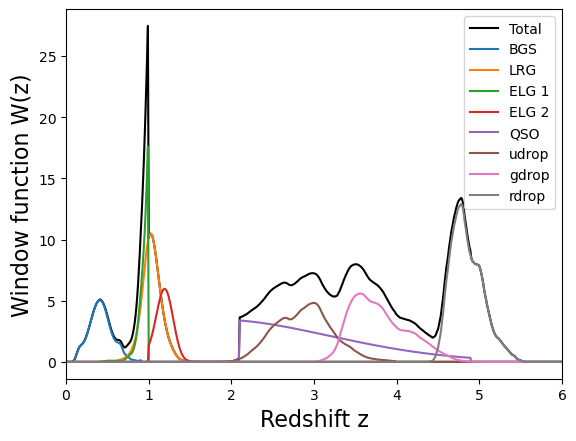

In [38]:
plt.plot(zs, Wkz_gs_BGS[0]+Wkz_gs_LRG[0]+Wkz_gs_ELG[0]+Wkz_gs_QSO[0]+Wkz_gs_udrop[0]+Wkz_gs_gdrop[0]+Wkz_gs_rdrop[0], 'k', label='Total')

plt.plot(zs, Wkz_gs_BGS[0], label='BGS')
plt.plot(zs, Wkz_gs_LRG[0], label='LRG')
plt.plot(zs, Wkz_gs_ELG[0], label='ELG 1')
plt.plot(zs, Wkz_gs_ELG[1], label='ELG 2')
plt.plot(zs, Wkz_gs_QSO[0], label='QSO')
plt.plot(zs, Wkz_gs_udrop[0], label='udrop')
plt.plot(zs, Wkz_gs_gdrop[0], label='gdrop')
plt.plot(zs, Wkz_gs_rdrop[0], label='rdrop')



plt.xlabel('Redshift z', fontsize=16)
plt.ylabel('Window function W(z)', fontsize=16)
plt.legend()

plt.xlim(0,6)

#### Get the power spectra of [kappa, CIB, MUST tracers]

In [ ]:
tracers = {'kappa':Wkz_k, 'CIB': Wkz_i,'BGS': Wkz_gs_BGS[0], 'LRG': Wkz_gs_LRG[0], 'ELG1': Wkz_gs_ELG[0], 'ELG2': Wkz_gs_ELG[1], 'udrop':Wkz_gs_udrop[0],'gdrop':Wkz_gs_gdrop[0],'rdrop':Wkz_gs_rdrop[0],}

# 初始化一个6x6的结果数组
result_matrix = np.zeros((len(tracers.keys()), len(tracers.keys()), lmax+1))

# 获取tracers的键名列表
tracer_keys = list(tracers.keys())

zmax = 1000   # corresponds to zmax=10


# 计算不同tracer组合之间的cal_LSS_power
for i, key1 in enumerate(tracer_keys):
    for j, key2 in enumerate(tracer_keys):
        W1 = tracers[key1][:zmax]
        W2 = tracers[key2][:zmax]
        result = cal_LSS_power(W1[:zmax], W2[:zmax], Hzs[:zmax], chi_values[:zmax], Plzs[:, :zmax], zs[:zmax], lmax+1)
        if i==j and i==1:
            result += clii_shot             # CIB shot noise
        if i==j and i>1:
            result += P_sn_MUST[i-2]        # Galaxy shot noise
        result_matrix[i, j, :] = result

integrating over z: 100%|██████████| 6144/6144 [00:04<00:00, 1396.30it/s]


In [40]:
rho_eff_MUST = 0
clii_inv = np.zeros((len(tracer_keys)-2, len(tracer_keys)-2, lmax+1))
for ell in range(lmax+1):
    clii = result_matrix[2:, 2:, ell]
    clii_inv[:, :, ell] = np.linalg.inv(clii)
for i in range(2, len(tracer_keys)):
    for j in range(2, len(tracer_keys)):
        rho_eff_MUST += result_matrix[0, i, :] * clii_inv[i-2, j-2, :] * result_matrix[0, j, :]
rho_eff_MUST /= clkk

rho_eff_MUST = np.sqrt(rho_eff_MUST)

In [41]:
rho_all = []

for i in range(1, 9):
    rho_all.append(result_matrix[0, i, :] / clkk**0.5 / (result_matrix[i, i, :])**0.5) 
rho_all = np.array(rho_all)


#### We note that CIB overwhelms the MUST across almost the whole ell range. However, in practice, CIB can be contaminated by Galaxy dust emission, and we usually exclude CIB at \ell < 100 to avoid this possible contamination. So MUST can still be a powerful supplement to the CIB as an external delensing proxy.

#### Imaging survey can be more suitable for external delensing thanks to its high surface density. However, spectropic survey may be used for 3D delensing to fully utilize its high-accurate redshift measurement.

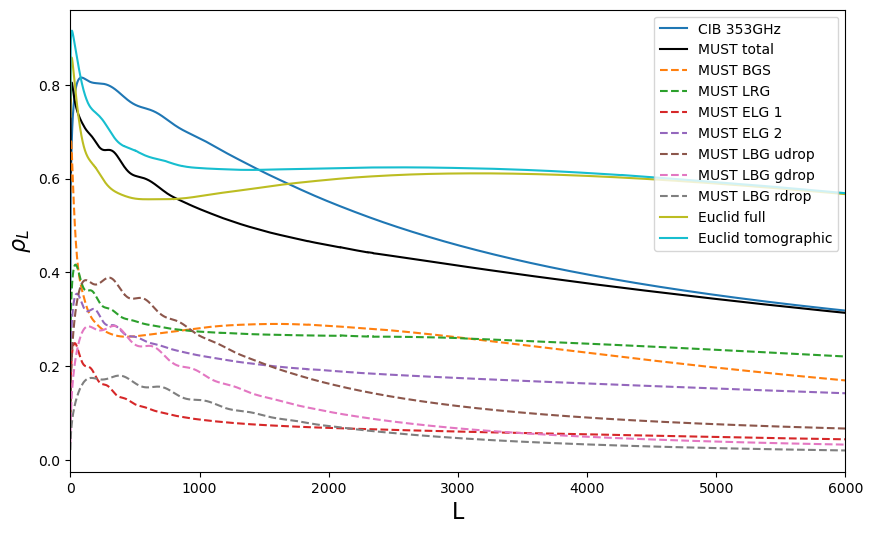

In [42]:
plt.figure(figsize=(10,6))

plt.plot(rho_all[0], label='CIB 353GHz')

plt.plot(rho_eff_MUST, 'k', label='MUST total')
plt.plot(rho_all[1], '--', label='MUST BGS')
plt.plot(rho_all[2], '--', label='MUST LRG')
plt.plot(rho_all[3], '--', label='MUST ELG 1')
plt.plot(rho_all[4], '--', label='MUST ELG 2')
plt.plot(rho_all[5], '--', label='MUST LBG udrop')
plt.plot(rho_all[6], '--', label='MUST LBG gdrop')
plt.plot(rho_all[7], '--', label='MUST LBG rdrop')

plt.plot(rhos_full[0], label='Euclid full')
plt.plot(rho_eff_euclid_tomo, label='Euclid tomographic')

#plt.plot(rho_ik, label='CIB')
#plt.semilogx()
plt.xlim(0,6000)
#plt.ylim(0.4, 1.0)

plt.xlabel('L', fontsize=16)
plt.ylabel(r'$\rho_L$', fontsize=16)
plt.legend()


In [43]:
np.save('/home/chen/Testarea/A_NEW_WORK_MAIN_revise/LSS_tracer_simulation/k_I_MUST_power_matrix.npy',result_matrix, )